# CS Capstone Project: Analyzing Tradeoffs between RNA-Sequencing Pseudoalignment Implementations

## Bradley Mont (UID: 804-993-030)

In [1]:
# beginning of code for running through Google Colab (do not execute if not using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd 'drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


In [3]:
!pip3 install Bio
# end of code for running through Google Colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 270 kB 5.2 MB/s 
     |████████████████████████████████| 2.3 MB 68.7 MB/s 


In [4]:
from Bio import SeqIO
from Bio.Seq import Seq
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import time
import copy

**Parameters**

In [5]:
# kmer length
k = 21

transcript_data_file_path = "transcriptome.fasta"

reads_data_file_path = "reads.fasta"

# if this flag is set to True, then for reads that initially do not pseudoalign with
# any of the transcripts, we attempt to pseudoalign with their reverse complement as well
# Note: setting this flag to True slows down program execution time, as a very
#       large proportion of the reads initially do not match any transcripts
attempt_reverse_complement = True

output_to_csv = True

**Read in RNA-seq data from FASTA files**

In [6]:
# read in transcriptome data
transcript_records = SeqIO.parse(transcript_data_file_path, "fasta")

In [7]:
# read in reads data from reads.fasta
read_records = SeqIO.parse(reads_data_file_path, "fasta")

# discard all fields from the record besides the sequence itself
reads = []
for record in read_records:
    reads.append(record.seq)

## Implementation 1: Hash Table

**Build the index for the hash-table based implementation**

In [8]:
# Map each kmer to a set of all of the isoforms that contain that kmer

building_hash_table_start_time = time.time()

kmer_to_matching_isoforms = defaultdict(set)

for transcript_record in transcript_records:
    transcript_sequence = transcript_record.seq
    
    for i in range(len(transcript_sequence) - k + 1):
        curr_kmer = transcript_sequence[i:(i+k)]
        
        # add this isoform to the set of isoforms that contain the current kmer
        kmer_to_matching_isoforms[curr_kmer].add(transcript_record.name)

time_taken_to_build_hash_table = (time.time() - building_hash_table_start_time) / 60
print("Time taken to build hash table index: {:0.3f} minutes".format(time_taken_to_build_hash_table))

Time taken to build hash table index: 0.399 minutes


**Naive Hash-Table Based Pseudoalignment Algorithm**

In [9]:
def compute_reverse_complement(read):
    
    # convert to list for mutability
    read = list(read)
    
    # complement each nucleotide
    for i, c in enumerate(read):
        if c == 'A':
            read[i] = 'T'
        elif c == 'T':
            read[i] = 'A'
        elif c == 'C':
            read[i] = 'G'
        elif c == 'G':
            read[i] = 'C'
            
    # reverse the read and convert back to Seq object
    return Seq(''.join(read[::-1]))

In [10]:
# keep track of the amount of reads that initially do not match any transcripts,
# but whose reverse complement aligns with at least 1 transcript
num_reads_with_rev_compl_aligned = 0

# I: a read sequence
# O: the read's equivalence class, which is represented by a set containing all of the
#    transcripts that the read pseudo-aligns to
def hash_table_pseudoalignment(read):
    
    global num_reads_with_rev_compl_aligned
    
    def compute_equivalence_class(read_seq):
        # initialize the equivalence class to be the matching transcripts for the 1st kmer
        first_kmer = read_seq[0:k]
        read_ec = kmer_to_matching_isoforms[first_kmer]

        # iterate through all of the read's other kmers
        for i in range(1, len(read_seq) - k + 1):
            curr_kmer = read_seq[i:(i+k)]
            curr_kmer_ec = kmer_to_matching_isoforms[curr_kmer]

            # take the intersection of this kmer's EC with the EC of the entire read so far
            read_ec = read_ec.intersection(curr_kmer_ec)

            # optimization: stop as soon as the intersection becomes empty
            # no point in further iterating
            if read_ec == set():
                return set()

        return read_ec
    
    read_equivalence_class = compute_equivalence_class(read)
    
    # if the read doesn't match any of the transcripts
    if len(read_equivalence_class) == 0 and attempt_reverse_complement:
        reverse_complement = compute_reverse_complement(read)
        rev_compl_equivalence_class = compute_equivalence_class(reverse_complement)
        
        if len(rev_compl_equivalence_class) > 0:
            # we successfully aligned the reverse complement to at least 1 transcript
            read_equivalence_class = rev_compl_equivalence_class 
            num_reads_with_rev_compl_aligned += 1
        
    # using a frozenset because the ec should be immutable
    # this allows us to use the ec as a dictionary key
    return frozenset(read_equivalence_class)

**Align Reads Using Hash Table Implementation**

In [11]:
hash_table_align_start_time = time.time()

equivalence_class_to_num_reads_hash_table = defaultdict(int)

for read in reads:
    curr_read_equivalence_class = hash_table_pseudoalignment(read)
    
    # increment the count for the number of reads of that equivalence class
    equivalence_class_to_num_reads_hash_table[curr_read_equivalence_class] += 1

hash_table_time_to_align = (time.time() - hash_table_align_start_time) / 60
print("Time taken to align using hash table index: {:0.3f} minutes".format(hash_table_time_to_align))

Time taken to align using hash table index: 3.492 minutes


In [12]:
if attempt_reverse_complement:   
    print("For reads that initially did not match any of the transcripts, we were able to match " + 
          str(num_reads_with_rev_compl_aligned) + " of these reads by aligning their reverse complements.")

For reads that initially did not match any of the transcripts, we were able to match 262300 of these reads by aligning their reverse complements.


## Implementation 2: Colored de Bruijn Graph

**Create the index for the Colored de Bruijn Graph implementation**

In [13]:
# go back to beginning of Fasta Iterator object to form Colored de Bruijn Graph
transcript_records = SeqIO.parse(transcript_data_file_path, "fasta")

In [14]:
building_de_bruijn_index_start_time = time.time()

# each graph node contains a kmer, as well as its equivalence class
# its equivalence class is represented as a set of the transcript names it pseudoaligns to
class Kmer_Info:
    def __init__(self, transcript_name, next_kmer=None):
        self.equivalence_class = set([transcript_name])
        self.kmers_pointing_to = set()
        if next_kmer:
            self.kmers_pointing_to.add(next_kmer)
            
        # this represents the amount to slide over to the next kmer to check
        # with the "skipping" optimization, this will potentially be more than 1
        self.branch_distance = 1

# the de Bruijn graph is represented as a dictionary
# key: kmer string
# value: Kmer_Info object for given kmer
de_bruijn_graph = dict()

for transcript_record in transcript_records:
    transcript_sequence = transcript_record.seq

    for i in range(len(transcript_sequence) - k):
        curr_kmer = transcript_sequence[i:(i+k)]
        
        next_kmer = transcript_sequence[(i+1):(i+k+1)]
        
        if curr_kmer in de_bruijn_graph:
            de_bruijn_graph[curr_kmer].equivalence_class.add(transcript_record.name)
            de_bruijn_graph[curr_kmer].kmers_pointing_to.add(next_kmer)
        else:
            de_bruijn_graph[curr_kmer] = Kmer_Info(transcript_record.name, next_kmer)
        
    # handle the last kmer separately since it has no next kmer
    last_kmer = transcript_sequence[(len(transcript_sequence) - k):]
    
    if last_kmer in de_bruijn_graph:
        de_bruijn_graph[last_kmer].equivalence_class.add(transcript_record.name)
    else:
        de_bruijn_graph[last_kmer] = Kmer_Info(transcript_record.name)

time_taken_to_build_de_bruijn_index = (time.time() - building_de_bruijn_index_start_time) / 60
print("Time taken to build de Bruijn graph index: {:0.3f} minutes".format(time_taken_to_build_de_bruijn_index))

Time taken to build de Bruijn graph index: 0.633 minutes


**Colored de Bruijn Graph Pseudoalignment Algorithm**

In [15]:
de_bruijn_reads_with_rev_comp_aligned = 0

# I: a read sequence
# O: the read's equivalence class, which is represented by a set containing all of the
# transcripts that the read pseudo-aligns to
def de_bruijn_pseudoalignment(de_bruijn_graph, read):
    
    global de_bruijn_reads_with_rev_comp_aligned
    
    def compute_equivalence_class(read_seq):
        # initialize the equivalence class to be the equivalence class for the 1st kmer
        first_kmer = read_seq[0:k]
        if first_kmer not in de_bruijn_graph:
            # the first kmer of the read matches no transcripts
            return set()
        
        first_kmer_node = de_bruijn_graph[first_kmer]
        
        valid_next_kmers = first_kmer_node.kmers_pointing_to
        
        read_ec = first_kmer_node.equivalence_class
 
        # iterate through the de Bruijn graph
        i = first_kmer_node.branch_distance

        while i < (len(read_seq) - k + 1):
            curr_kmer = read_seq[i:(i+k)]
            
            # see if the curr_kmer matches any of the valid nodes in our path in the de Bruijn graph
            if curr_kmer not in valid_next_kmers:
                # the read does not match any of the transcripts
                return set()
                
            curr_kmer_node = de_bruijn_graph[curr_kmer]
            curr_kmer_ec = curr_kmer_node.equivalence_class
            
            # take the intersection of this kmer's EC with the EC of the entire read so far
            read_ec = read_ec.intersection(curr_kmer_ec)
            
            # optimization: stop as soon as the intersection becomes empty
            # no point in further iterating
            if read_ec == set():
                return set()
            
            # increment i by the skip length for the current node
            i += curr_kmer_node.branch_distance
            
            # update the valid next hops
            valid_next_kmers = curr_kmer_node.kmers_pointing_to
            
        return read_ec
    
    read_equivalence_class = compute_equivalence_class(read)
    
    # if the read doesn't match any of the transcripts
    if len(read_equivalence_class) == 0 and attempt_reverse_complement:
        reverse_complement = compute_reverse_complement(read)
        rev_compl_equivalence_class = compute_equivalence_class(reverse_complement)

        if len(rev_compl_equivalence_class) > 0:
            # we successfully aligned the reverse complement to at least 1 transcript
            read_equivalence_class = rev_compl_equivalence_class
            de_bruijn_reads_with_rev_comp_aligned += 1

    # using a frozenset because the ec should be immutable
    # this allows us to use the ec as a dictionary key
    return frozenset(read_equivalence_class)

**Align Reads Using Colored de Bruijn Graph Implementation**

In [16]:
de_bruijn_align_start_time = time.time()

equivalence_class_to_num_reads_de_bruijn = defaultdict(int)

for read in reads:
    curr_read_equivalence_class = de_bruijn_pseudoalignment(de_bruijn_graph, read)

    # increment the count for the number of reads of that equivalence class
    equivalence_class_to_num_reads_de_bruijn[curr_read_equivalence_class] += 1

de_bruijn_time_to_align = (time.time() - de_bruijn_align_start_time) / 60
print("Time taken to align using de Bruijn graph index: {:0.3f} minutes".format(de_bruijn_time_to_align))

Time taken to align using de Bruijn graph index: 4.707 minutes


In [17]:
if attempt_reverse_complement:   
    print("For reads that initially did not match any of the transcripts, we were able to match " + 
          str(de_bruijn_reads_with_rev_comp_aligned) + " of these reads by aligning their reverse complements.")
    
de_bruijn_reads_with_rev_comp_aligned = 0

For reads that initially did not match any of the transcripts, we were able to match 262300 of these reads by aligning their reverse complements.


## Implementation 3: Colored de Bruijn Graph Augmented with "Skipping" Optimization

**Create the index for the Colored de Bruijn Graph implementation with "Skipping" Optimization**

In [18]:
optimizing_de_bruijn_index_start_time = time.time()

optimized_de_bruijn_graph = copy.deepcopy(de_bruijn_graph)

seen_kmers = set()

for kmer in optimized_de_bruijn_graph:

    if kmer in seen_kmers:
        continue

    curr_kmer = kmer
    curr_kmer_node = optimized_de_bruijn_graph[curr_kmer]
    
    # map each k-mer in the current path to its offset from the beginning
    kmers_in_path_to_offset = dict()
    curr_offset = 0

    loop = False
    
    while len(curr_kmer_node.kmers_pointing_to) == 1:
        if curr_kmer in kmers_in_path_to_offset:
            loop = True
            break

        kmers_in_path_to_offset[curr_kmer] = curr_offset
        curr_offset += curr_kmer_node.branch_distance
        
        curr_kmer = next(iter(curr_kmer_node.kmers_pointing_to))
        curr_kmer_node = optimized_de_bruijn_graph[curr_kmer]

    if loop:
        continue

    # update branch distances and valid kmers for all nodes in current path

    new_next_kmers = optimized_de_bruijn_graph[curr_kmer].kmers_pointing_to

    for path_kmer, path_offset in kmers_in_path_to_offset.items():
        new_branch_dist = curr_offset + 1 - path_offset 
        optimized_de_bruijn_graph[path_kmer].branch_distance = new_branch_dist
        optimized_de_bruijn_graph[path_kmer].kmers_pointing_to = new_next_kmers

    seen_kmers = seen_kmers.union(kmers_in_path_to_offset.keys())
    seen_kmers.add(curr_kmer)

time_taken_to_optimize_de_bruijn_index = (time.time() - optimizing_de_bruijn_index_start_time) / 60
print("Time taken to build de Bruijn graph index: {:0.3f} minutes".format(time_taken_to_optimize_de_bruijn_index))

Time taken to build de Bruijn graph index: 11.141 minutes


**Align Reads Using Colored de Bruijn Graph Implementation with "Skipping" Optimization**

In [19]:
optimized_de_bruijn_align_start_time = time.time()

equivalence_class_to_num_reads_skipping = defaultdict(int)

for read in reads:
    curr_read_equivalence_class = de_bruijn_pseudoalignment(optimized_de_bruijn_graph, read)

    # increment the count for the number of reads of that equivalence class
    equivalence_class_to_num_reads_skipping[curr_read_equivalence_class] += 1

optimized_de_bruijn_time_to_align = (time.time() - optimized_de_bruijn_align_start_time) / 60
print("Time taken to align using Optimized de Bruijn graph index: {:0.3f} minutes".format(optimized_de_bruijn_time_to_align))

Time taken to align using Optimized de Bruijn graph index: 1.031 minutes


In [20]:
if attempt_reverse_complement:   
    print("For reads that initially did not match any of the transcripts, we were able to match " + 
          str(de_bruijn_reads_with_rev_comp_aligned) + " of these reads by aligning their reverse complements.")

For reads that initially did not match any of the transcripts, we were able to match 257943 of these reads by aligning their reverse complements.


## Analyzing Equivalence Class Data

**Create pandas DataFrames containing the Pseudoalignment data**

In [21]:
def create_dataframe(equivalence_class_to_num_reads):
    equivalence_class_data = []

    for equivalence_class in equivalence_class_to_num_reads:
        curr_row = []

        # count
        curr_row.append(equivalence_class_to_num_reads[equivalence_class])

        # number of items in equivalence class
        curr_row.append(len(equivalence_class))

        # isoforms in equivalence class
        curr_row.append(', '.join(equivalence_class))

        equivalence_class_data.append(curr_row)
        
    column_names = ['# of reads', '# of items in equivalence class', 'isoforms in equivalence class']
    equivalence_class_df = pd.DataFrame(equivalence_class_data, columns=column_names)
    return equivalence_class_df

hash_table_ec_df = create_dataframe(equivalence_class_to_num_reads_hash_table)
de_bruijn_ec_df = create_dataframe(equivalence_class_to_num_reads_de_bruijn)
skipping_ec_df = create_dataframe(equivalence_class_to_num_reads_skipping)

**Sort the DataFrames by counts descending**

In [22]:
hash_table_ec_df = hash_table_ec_df.sort_values(by=['# of reads'], ascending=False)
de_bruijn_ec_df = de_bruijn_ec_df.sort_values(by=['# of reads'], ascending=False)
skipping_ec_df = skipping_ec_df.sort_values(by=['# of reads'], ascending=False)

**Write Equivalence Class counts for Pseudoalignment Implementations to CSV files**

In [23]:
if output_to_csv:
    hash_table_ec_df.to_csv(path_or_buf='hash_table_output.csv', index=False)
    de_bruijn_ec_df.to_csv(path_or_buf='de_bruijn_output.csv', index=False)
    skipping_ec_df.to_csv(path_or_buf='skipping_de_bruijn_output.csv', index=False)

For measuring equivalence class data, we will only analyze the results obtained using the unoptimized Colored de Bruijn Graph implementation, since all results were extremely similar and this implementation should theoretically be the most accurate.

**Basic Statistics about Equivalence Classes**

In [24]:
de_bruijn_ec_df.describe()

,# of reads,# of items in equivalence class
count,2744.000000,2744.000000
mean,467.392857,4.950802
std,14128.004375,4.521684
min,1.000000,0.000000
25%,2.000000,2.000000
50%,9.000000,4.000000
75%,49.000000,7.000000
max,737392.000000,54.000000


In [25]:
print("The 10 equivalence classes with the most reads mapping to them:")

de_bruijn_ec_df.head(n=10)

The 10 equivalence classes with the most reads mapping to them:


,# of reads,# of items in equivalence class,isoforms in equivalence class
2,737392,0,
2660,50420,2,"ENST00000329251, ENST00000496634"
1661,12500,1,ENST00000536684
2709,11681,1,ENST00000393067
2625,10042,5,"ENST00000389939, ENST00000345732, ENST00000674..."
2064,10039,7,"ENST00000422447, ENST00000545215, ENST00000379..."
2717,9344,1,ENST00000260197
2634,9020,1,ENST00000449131
2636,8939,6,"ENST00000532829, ENST00000534180, ENST00000526..."
513,8168,3,"ENST00000530797, ENST00000321153, ENST00000530398"


**Histograms**

In order to more clearly show the cardinalities of each column, I have created multiple histograms with differing bucket ranges.

**Histograms of Read Counts of Equivalence Classes (1-10 reads)**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f90c886eb90>]],
      dtype=object)

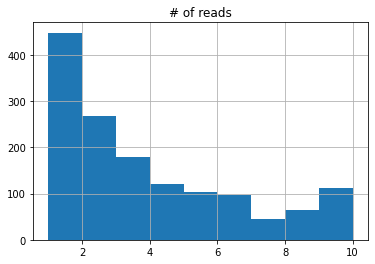

In [26]:
de_bruijn_ec_df.hist(column='# of reads', bins=[1,2,3,4,5,6,7,8,9,10])

**Histograms of Read Counts of Equivalence Classes (10-100 reads)**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f90c8e1c190>]],
      dtype=object)

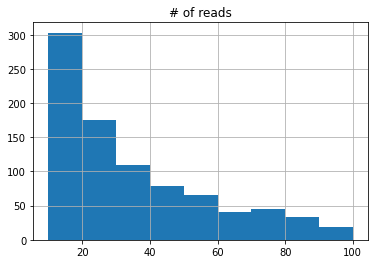

In [27]:
de_bruijn_ec_df.hist(column='# of reads', bins=[10,20,30,40,50,60,70,80,90,100])

**Histograms of Read Counts of Equivalence Classes (100-1000 reads)**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f90cae7d190>]],
      dtype=object)

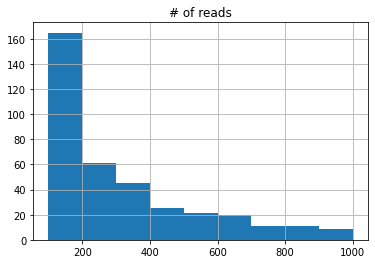

In [28]:
de_bruijn_ec_df.hist(column='# of reads', bins=[100,200,300,400,500,600,700,800,900,1000])

**Histograms of Read Counts of Equivalence Classes (1000+ reads)**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f90d3a87490>]],
      dtype=object)

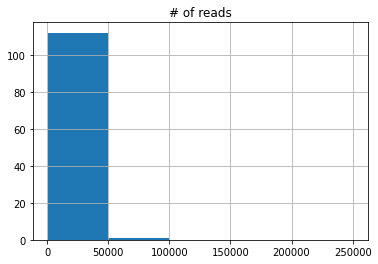

In [29]:
de_bruijn_ec_df.hist(column='# of reads', bins=[1000,50000,100000,250000])

**Histograms of # of Isoforms of Equivalence Classses (1-15 isoforms)**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f90d5005990>]],
      dtype=object)

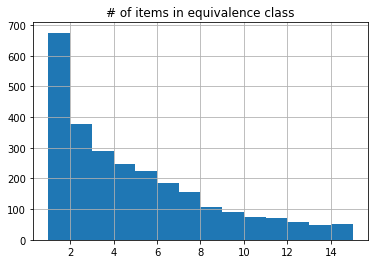

In [30]:
de_bruijn_ec_df.hist(column='# of items in equivalence class', bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

**Histograms of # of Isoforms of Equivalence Classses (15-60 isoforms)**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f90df1cd290>]],
      dtype=object)

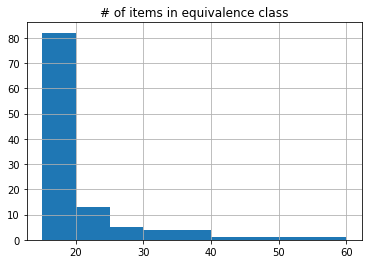

In [31]:
de_bruijn_ec_df.hist(column='# of items in equivalence class', bins=[15,20,25,30,40,50,60])

## Comparing Performance of Three Implementations

**Plot Time Taken to Build Index for each Implementation**

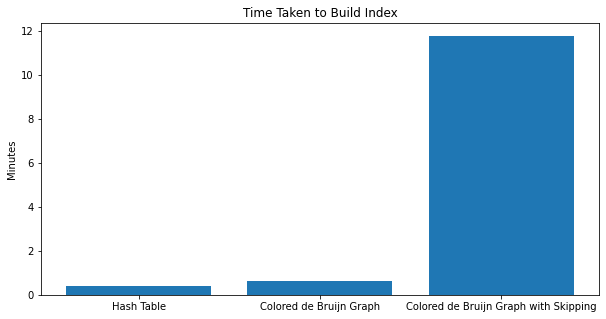

In [32]:
plt.figure(figsize=(10, 5))
plt.bar(
    x=['Hash Table','Colored de Bruijn Graph','Colored de Bruijn Graph with Skipping'],
    height=[time_taken_to_build_hash_table, time_taken_to_build_de_bruijn_index, time_taken_to_build_de_bruijn_index + time_taken_to_optimize_de_bruijn_index])
plt.title('Time Taken to Build Index')
plt.ylabel("Minutes")

plt.show()

**Plot Time Taken to Pseudoalign Reads for each Implementation**

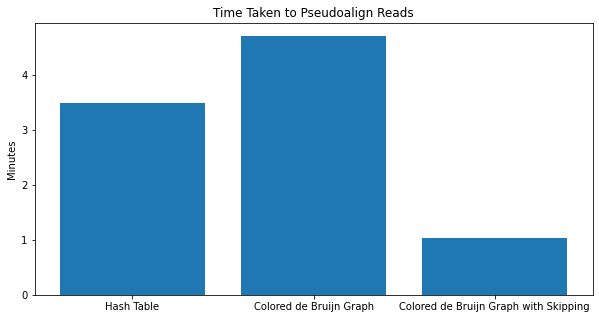

In [33]:
plt.figure(figsize=(10, 5))
plt.bar(
    x=['Hash Table','Colored de Bruijn Graph','Colored de Bruijn Graph with Skipping'],
    height=[hash_table_time_to_align, de_bruijn_time_to_align, optimized_de_bruijn_time_to_align])
plt.title('Time Taken to Pseudoalign Reads')
plt.ylabel("Minutes")

plt.show()